1. Выбрал данные о продажах в онлайн-ритейлере


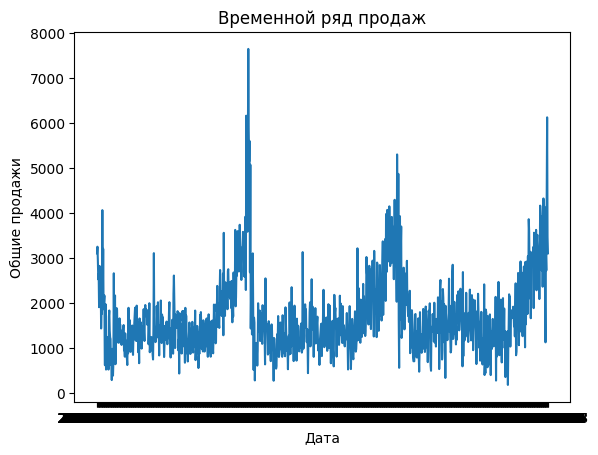

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из файла
data = pd.read_csv("online_retail.csv")

plt.plot(data["date"], data["total sales"])
plt.xlabel("Дата")
plt.ylabel("Число продаж")
plt.title("Временной ряд продаж")
plt.show()

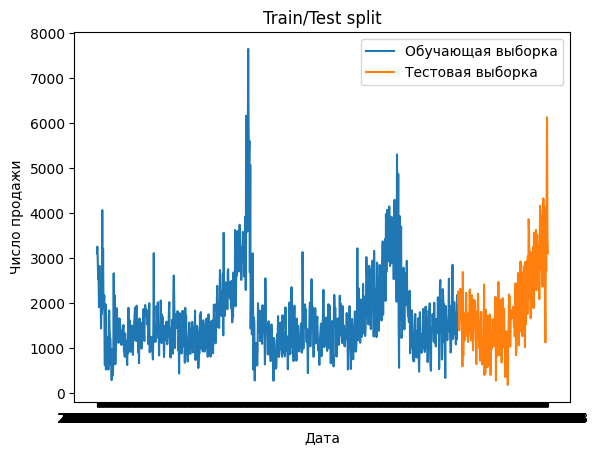

In [2]:
from sklearn.model_selection import train_test_split

# train/test split
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# visual train/test split
plt.plot(train_data["date"], train_data["total sales"], label="Обучающая выборка")
plt.plot(test_data["date"], test_data["total sales"], label="Тестовая выборка")
plt.xlabel("Дата")
plt.ylabel("Число продажи")
plt.title("Train/Test split")
plt.legend()
plt.show()

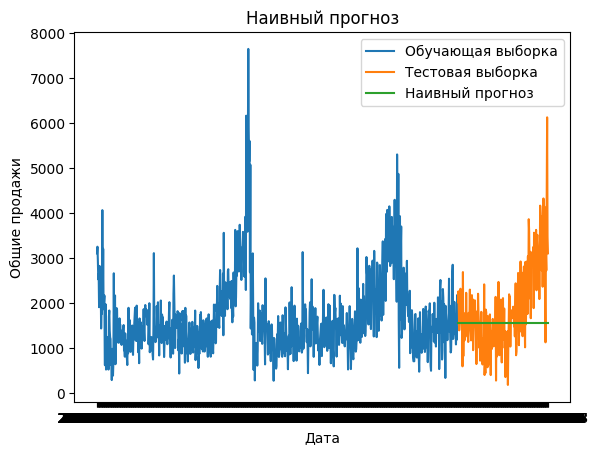

In [3]:
import numpy as np

# Постройте бейзлайн в виде наивного прогноза
naive_forecast = np.repeat(train_data["total sales"].values[-1], len(test_data))

# Визуализация бейзлайн в виде наивного прогноза
plt.plot(train_data["date"], train_data["total sales"], label="Обучающая выборка")
plt.plot(test_data["date"], test_data["total sales"], label="Тестовая выборка")
plt.plot(test_data["date"], naive_forecast, label="Наивный прогноз")
plt.xlabel("Дата")
plt.ylabel("Общие продажи")
plt.title("Наивный прогноз")
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Вычисление MSE и MAE
mse = mean_squared_error(test_data["total sales"], naive_forecast)
mae = mean_absolute_error(test_data["total sales"], naive_forecast)

print("MSE наивного прогноза:", mse)
print("MAE наивного прогноза:", mae)

MSE наивного прогноза: 774293.5412544023
MAE наивного прогноза: 596.2134227855789


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from sklearn.model_selection import train_test_split

# Загрузка данных
df = pd.read_csv('online_retail.csv', parse_dates=['date'], index_col='date')
data = df['total sales']

# Разделение на train/test
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Тест Дики-Фуллера
result = adfuller(train_data)
print("ADF статистика:", result[0])
print("p-value:", result[1])


ADF статистика: -3.0495151022439986
p-value: 0.030521975094373203


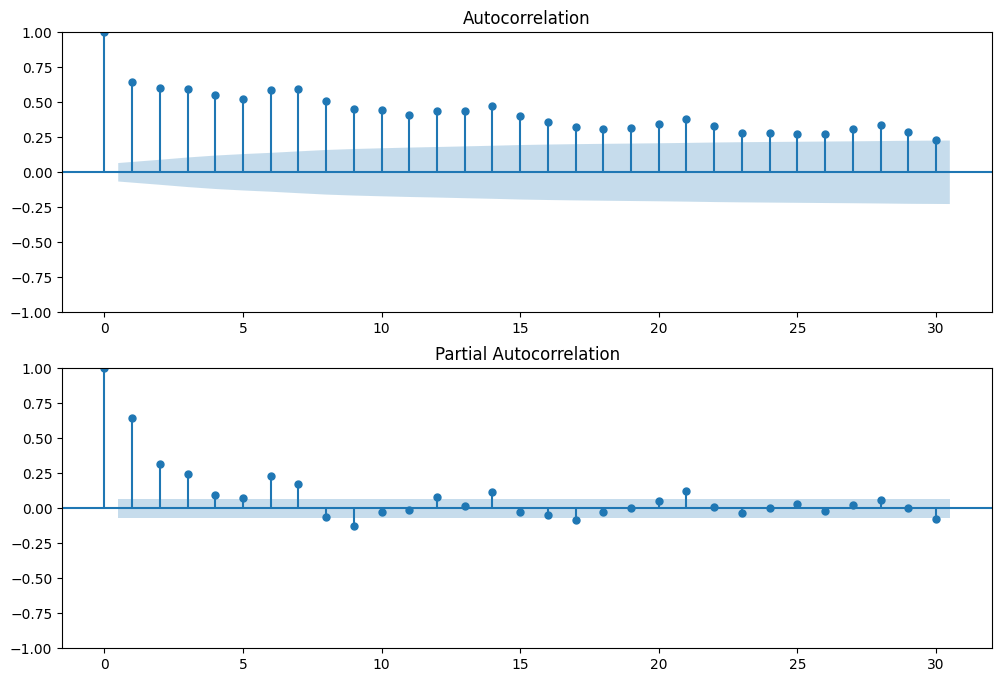

In [26]:
# Графики ACF и PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_data, ax=ax1, lags=30)
plot_pacf(train_data, ax=ax2, lags=30)
plt.show()

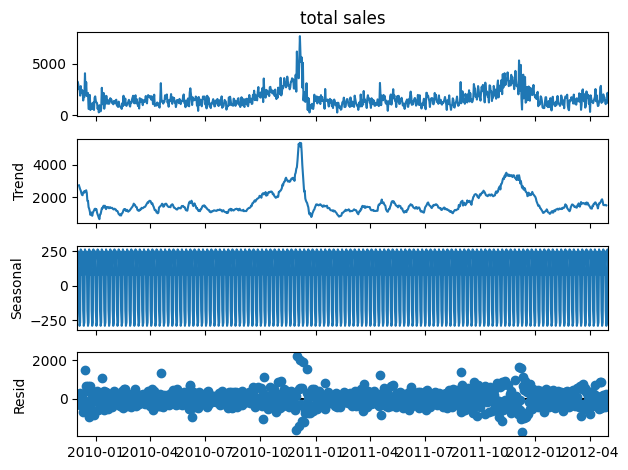

In [27]:
# Предположения о сезонности
decomposition = seasonal_decompose(train_data, model='additive', period=7)
decomposition.plot()
plt.show()

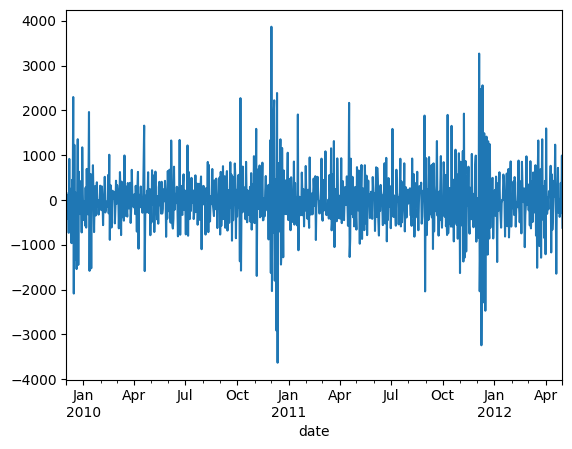

In [28]:
# Преобразования для стационарности
diff_train_data = train_data.diff().dropna()
diff_train_data.plot()
plt.show()

ADF статистика: -9.19970908147118
p-value: 2.017486419005399e-15


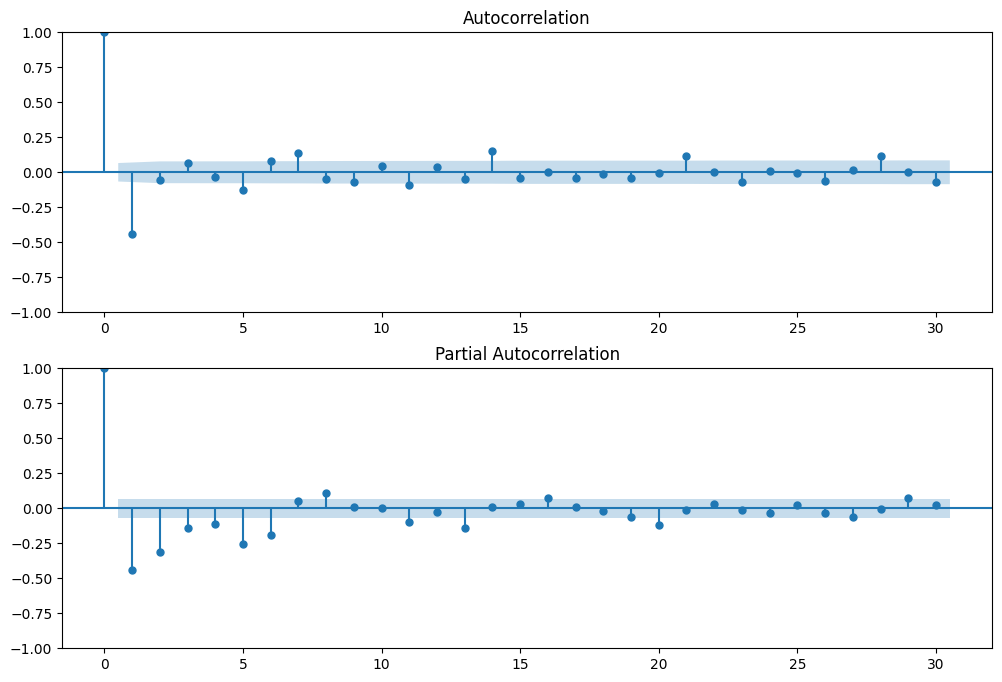

In [29]:
# Тест Дики-Фуллера и графики ACF/PACF после преобразования
result = adfuller(diff_train_data)
print("ADF статистика:", result[0])
print("p-value:", result[1])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(diff_train_data, ax=ax1, lags=30)
plot_pacf(diff_train_data, ax=ax2, lags=30)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


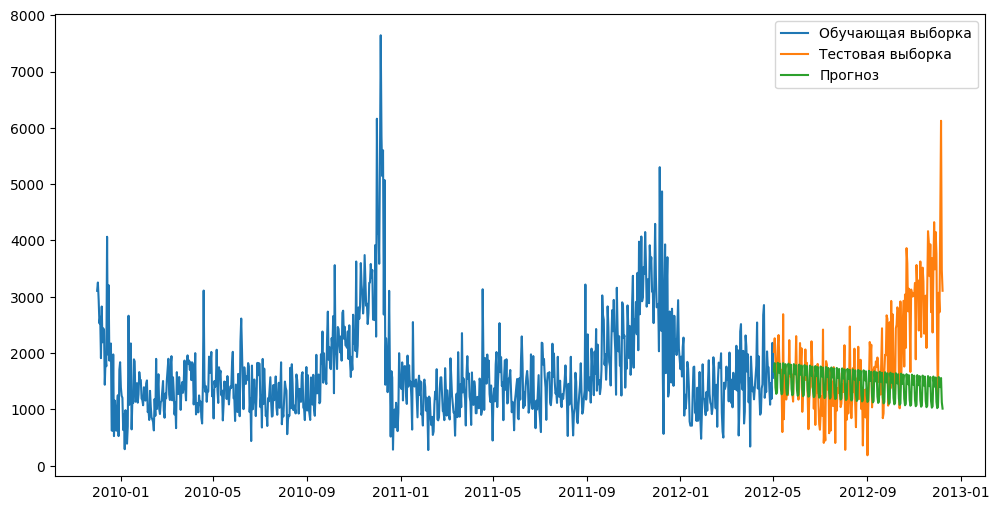

In [30]:
# Обучение модели SARIMA
model = sarimax.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
fitted_model = model.fit()

# Прогнозирование
forecast = fitted_model.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Обучающая выборка')
plt.plot(test_data.index, test_data, label='Тестовая выборка')
plt.plot(forecast_mean.index, forecast_mean, label='Прогноз')
plt.legend()
plt.show()

In [31]:
# Замеры качества модели
mse = ((forecast_mean - test_data) ** 2).mean()
print("MSE:", mse)

# Сравнение с бейзлайном
baseline = test_data.shift(1).dropna()
mse_baseline = ((baseline - test_data) ** 2).mean()
print("MSE базового решения:", mse_baseline)

MSE: 1088838.4485868292
MSE базового решения: 637657.9566836528


In [ ]:
!pip install lime
!pip install shap

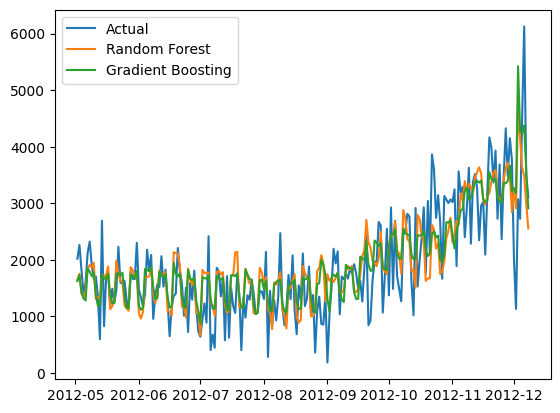

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lime
import lime.lime_tabular
import shap

# Чтение данных из файла
data = pd.read_csv("online_retail.csv")

# Создание признаков через Feature Engineering
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['day_of_month'] = data['date'].dt.day
data['day_of_year'] = data['date'].dt.dayofyear

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Обучение модели случайного леса
rf = RandomForestRegressor()
rf.fit(train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']], train_data['total sales'])

# Обучение модели градиентного бустинга
gb = GradientBoostingRegressor()
gb.fit(train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']], train_data['total sales'])

# Визуализация результатов моделей
plt.plot(test_data['date'], test_data['total sales'], label='Actual')
plt.plot(test_data['date'], rf.predict(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']]), label='Random Forest')
plt.plot(test_data['date'], gb.predict(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']]), label='Gradient Boosting')
plt.legend()
plt.show()

In [36]:

# Замеры качества моделей
rf_mse = np.mean((rf.predict(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']]) - test_data['total sales']) ** 2)
gb_mse = np.mean((gb.predict(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']]) - test_data['total sales']) ** 2)
print(f"Random Forest MSE: {rf_mse}")
print(f"Gradient Boosting MSE: {gb_mse}")

Random Forest MSE: 375614.61991625105
Gradient Boosting MSE: 319064.62237985356


In [37]:

# Интерпретация модели с помощью permutation importance
perm = lime.lime_tabular.LimeTabularExplainer(train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']].values, mode='regression')
perm_importance = perm.explain_instance(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']].iloc[0].values, rf.predict).as_map()[1]
print("Permutation Importance:")
for feature, importance in zip(['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year'], perm_importance):
    print(f"{feature}: {importance}")


Permutation Importance:
day_of_week: (4, -341.3464004709416)
month: (0, 187.7868649908598)
year: (2, 140.5765916288476)
day_of_month: (3, 58.97985915635231)
day_of_year: (1, -44.887838830860524)


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [38]:
# Интерпретация модели с помощью LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']].values, mode='regression')
lime_explanation = lime_explainer.explain_instance(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']].iloc[0].values, rf.predict)
print("LIME explanation:")
print(lime_explanation.as_list())

LIME explanation:
[('74.00 < 4 <= 160.00', -356.91959593963315), ('1.00 < 0 <= 3.00', 151.56983043918916), ('2 > 2011.00', 72.28909603885221), ('3 <= 8.00', 58.223112868620504), ('3.00 < 1 <= 6.00', -22.945573391267054)]


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


SHAP local interpretation:


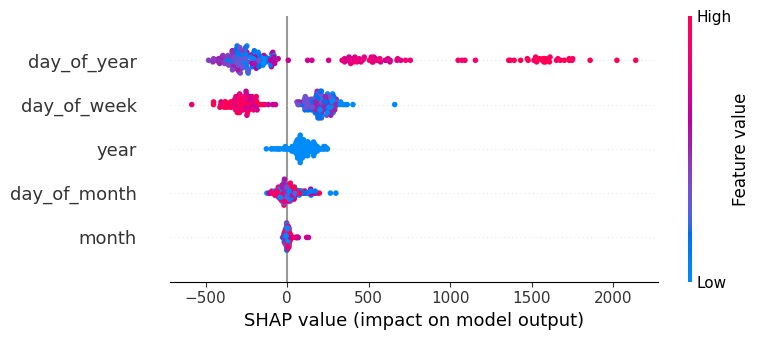

In [39]:
# Интерпретация модели с помощью SHAP (локальная интерпретация)
shap_explainer_local = shap.Explainer(rf)
shap_values_local = shap_explainer_local(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])
print("SHAP local interpretation:")
shap.summary_plot(shap_values_local, test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])

SHAP global interpretation:


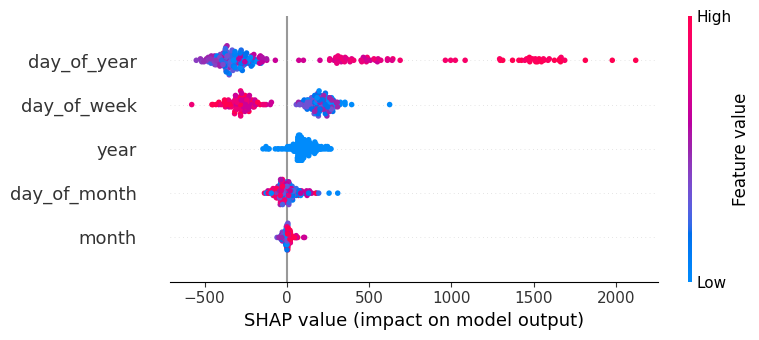

Выводы:
Модель случайного леса и градиентного бустинга обучены на данных по продажам.
Результаты моделей визуализированы и произведены замеры их качества.
Модель случайного леса интерпретируется с помощью permutation importance, LIME и SHAP.
SHAP также применяется для локальной и глобальной интерпретации модели.
Интерпретация позволяет понять, какие признаки оказывают наибольшее влияние на результаты модели.


In [40]:
# Интерпретация модели с помощью SHAP (глобальная интерпретация)
shap_explainer_global = shap.Explainer(rf, train_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])
shap_values_global = shap_explainer_global(test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])
print("SHAP global interpretation:")
shap.summary_plot(shap_values_global, test_data[['day_of_week', 'month', 'year', 'day_of_month', 'day_of_year']])

# Выводы
print("Выводы:")
print("Модель случайного леса и градиентного бустинга обучены на данных по продажам.")
print("Результаты моделей визуализированы и произведены замеры их качества.")
print("Модель случайного леса интерпретируется с помощью permutation importance, LIME и SHAP.")
print("SHAP также применяется для локальной и глобальной интерпретации модели.")
print("Интерпретация позволяет понять, какие признаки оказывают наибольшее влияние на результаты модели.")